[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Priesemann-Group/covid19_inference/blob/model_cleanup/scripts/interactive/example_one_bundesland.ipynb)

#Extending the Repository

In [117]:
!pip install git+https://github.com/Priesemann-Group/covid19_inference.git

  Cloning https://github.com/Priesemann-Group/covid19_inference.git to /tmp/pip-req-build-tepu9rvk
  Running command git clone -q https://github.com/Priesemann-Group/covid19_inference.git /tmp/pip-req-build-tepu9rvk
  Created wheel for covid19-inference: filename=covid19_inference-0.1.8a0-cp36-none-any.whl size=103637 sha256=714a20d19c445aa8b0fadaf0a942f490c2ec1b5484a690375bd6858cfeb898ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-01ts2kjb/wheels/da/f1/e7/da56ba4fe019b70927b4bb10088f02f672b31b69fd54a6e613
Successfully built covid19-inference


#Importing modules
*italicized text*

In [118]:
import datetime
import time as time_module
import sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats
import theano
import theano.tensor as tt
import pymc3 as pm

#Importing the Extended Repository

In [119]:
# Now to the fun stuff, we import our module!
try:
    import covid19_inference as cov19
except ModuleNotFoundError:
    sys.path.append("../../")
    import covid19_inference as cov19

#Task 2.1 Starts here

a. **Download the COVID19 case data for your assigned country**


In [120]:
jhu = cov19.data_retrieval.JHU()
jhu.download_all_available_data()
# One could also parse True to the constructor of the class to force an auto download

INFO     [covid19_inference.data_retrieval._JHU] Successfully loaded data from local


In [121]:
bd = datetime.datetime(2020, 3, 26)  # beggining date retrieved from the report of ifm
ed = datetime.datetime.now()        # until today(relative whenever you read this code it is today)

In [122]:
total_cases_obs = jhu.get_total(
    value="confirmed", country="Ghana", data_begin=bd, data_end=ed
)
new_cases_obs = jhu.get_new(
    value="confirmed", country="Ghana", data_begin=bd, data_end=ed
)

b. Pre-process the downloaded data such that the starting date of the data is when the number of covid19 cases in your country reaches 100 and dominated by a community transmission.

In [123]:
total_cases_obs =  total_cases_obs[total_cases_obs>=100] # making the first case to be taken from the first 100 case and forward
total_cases_obs # in ourcase the first case is 132 and on march 26

date
2020-03-26      132
2020-03-27      137
2020-03-28      141
2020-03-29      152
2020-03-30      152
              ...  
2020-08-03    37812
2020-08-04    37812
2020-08-05    39075
2020-08-06    39642
2020-08-07    40097
Name: confirmed, Length: 135, dtype: int64

plotting to see if the given dataset makes sense



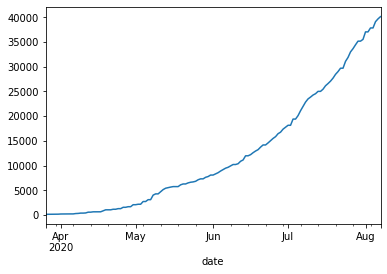

In [124]:
total_cases_obs.plot()

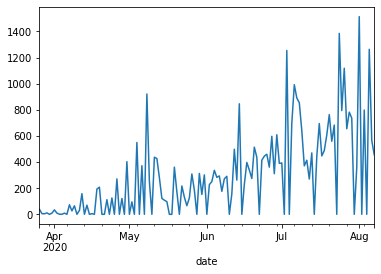

In [125]:
new_cases_obs.plot()

c. **It is unlikely but, if there are dates that have NaN values, perform linear regression to fill these missing values**. **Make sure the final data has a continuous date - ensure no date is missing. Zero number of cases for a given date is ok**.


In [126]:
#checking for missing values
total_cases_obs[total_cases_obs.isnull()]

Series([], Name: confirmed, dtype: int64)

In [127]:
new_cases_obs[new_cases_obs.isnull()]


Series([], Name: confirmed, dtype: int64)

* From above we can see that there is no missing value for both total confirmed case as well as for new cases since the output from checking the missing value is empty

# d. Split the data into one part used for inference (training set), and an other used for to validate a forecast (validation set):

1.  **Training set** includes all dates from the time the community transmission reaches 100 to July 25 2020.
2.  Validation set includes dates from 25 July 2020 to one final date in the covid19 cases data.  



In [128]:
new_cases_obs = new_cases_obs[new_cases_obs.index <= '2020-07-25'] # training set
val_set = new_cases_obs[new_cases_obs.index > '2020-07-25'] #validation set

# e. Plot the training data together with the model that is sampled from the posterior of the SIR model. The posterior of the SIR model means distributions on the Lambda, Mu, and other parameters. A single model curve means a single sample from the posterior distribution.

#### Creating the model

First we need to set the priors for the change points and other configs.


In [129]:
diff_data_sim = 16  # should be significantly larger than the expected delay, in
# order to always fit the same number of data points.
num_days_forecast = 15 # we took this 15 becasue from july 26 - august 10 it is 15 days


In [130]:
# We set the priors for the changepoints here
prior_date_mild_dist_begin = datetime.datetime(2020, 3, 30)
prior_date_strong_dist_begin = datetime.datetime(2020, 6, 15)
prior_date_contact_ban_begin = datetime.datetime(2020, 7, 26)

In [131]:
change_points = [
    dict(
        pr_mean_date_transient=prior_date_mild_dist_begin,
        pr_sigma_date_transient=3,
        pr_median_lambda=0.2,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_strong_dist_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8,
        pr_sigma_lambda=1,
    ),
    dict(
        pr_mean_date_transient=prior_date_contact_ban_begin,
        pr_sigma_date_transient=1.5,
        pr_median_lambda=1 / 8 / 2,
        pr_sigma_lambda=1,
    ),
]



Next, we create the model! There are default values for most of the function arguments,
but we will try to explicitly set all kwargs for the sake of this example.


In [80]:
params_model = dict(
    new_cases_obs=new_cases_obs[:],
    data_begin=bd,
    fcast_len=num_days_forecast,
    diff_data_sim=diff_data_sim,
    N_population=31072940,
)
# Median of the prior for the delay in case reporting, we assume 10 days
pr_delay = 3



The model is specified in a context. Each function in this context
has access to the model parameters set.


In [81]:
with cov19.model.Cov19Model(**params_model) as this_model:
    # Create the an array of the time dependent infection rate lambda
    lambda_t_log = cov19.model.lambda_t_with_sigmoids(
        pr_median_lambda_0=0.4,
        pr_sigma_lambda_0=0.5,
        change_points_list=change_points,  # The change point priors we constructed earlier
        name_lambda_t="lambda_t",  # Name for the variable in the trace (see later)
    )

    # set prior distribution for the recovery rate
    mu = pm.Lognormal(name="mu", mu=np.log(1 / 8), sigma=0.2)

    # This builds a decorrelated prior for I_begin for faster inference.
    # It is not necessary to use it, one can simply remove it and use the default argument
    # for pr_I_begin in cov19.SIR
    prior_I = cov19.model.uncorrelated_prior_I(
        lambda_t_log=lambda_t_log,
        mu=mu,
        pr_median_delay=pr_delay,
        name_I_begin="I_begin",
        name_I_begin_ratio_log="I_begin_ratio_log",
        pr_sigma_I_begin=2,
        n_data_points_used=5,
    )

    # Use lambda_t_log and mu to run the SIR model
    new_cases = cov19.model.SIR(
        lambda_t_log=lambda_t_log,
        mu=mu,
        name_new_I_t="new_I_t",
        name_I_t="I_t",
        name_I_begin="I_begin",
        pr_I_begin=prior_I,
    )

    # Delay the cases by a lognormal reporting delay
    new_cases = cov19.model.delay_cases(
        cases=new_cases,
        name_cases="delayed_cases",
        name_delay="delay",
        name_width="delay-width",
        pr_mean_of_median=pr_delay,
        pr_sigma_of_median=0.2,
        pr_median_of_width=0.3,
    )

    # Modulate the inferred cases by a abs(sin(x)) function, to account for weekend effects
    # Also adds the "new_cases" variable to the trace that has all model features.
    new_cases = cov19.model.week_modulation(
        cases=new_cases,
        name_cases="new_cases",
        name_weekend_factor="weekend_factor",
        name_offset_modulation="offset_modulation",
        week_modulation_type="abs_sine",
        pr_mean_weekend_factor=0.3,
        pr_sigma_weekend_factor=0.5,
        weekend_days=(6, 7),
    )

    # Define the likelihood, uses the new_cases_obs set as model parameter
    cov19.model.student_t_likelihood(new_cases)

INFO     [covid19_inference.model.spreading_rate] Lambda_t with sigmoids
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO     [covid19_inference.model.model] relative_to_previous was set to default value False
INFO     [covid19_inference.model.model] pr_factor_to_previous was set to default value 1
INFO     [covid19_inference.model.model] pr_median_transient_len was set to default value 4
INFO     [covid19_inference.model.model] pr_sigma_transient_len was set to default value 0.5
INFO  


## MCM sampling

After the model is built, it is sampled using an MCMC sampler.
The number of parallel runs can be set with the argument `cores=`.
In particular, due to a bug in Theano, Windows users should set `cores=1`.
The sampling can take a long time.


In [82]:
trace = pm.sample(model=this_model, cores=4, tune=50, draws=100, init="advi+adapt_diag")

Only 100 samples in chain.
WARNING  [pymc3] Only 100 samples in chain.
Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO     [pymc3] Initializing NUTS using advi+adapt_diag...
Average Loss = 907.13:  12%|█▏        | 23194/200000 [04:02<30:51, 95.50it/s] 
Convergence achieved at 23200
INFO     [pymc3.variational.inference] Convergence achieved at 23200
Interrupted at 23,199 [11%]: Average Loss = 988.66
INFO     [pymc3.variational.inference] Interrupted at 23,199 [11%]: Average Loss = 988.66
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma_obs, offset_modulation_rad, weekend_factor_log, delay_log, I_begin_ratio_log, mu, transient_len_3_log_, transient_len_2_log_, transient_len_1_log_, transient_day_3, transient_day_2, transient_day_1, lambda_3_log_, lambda_2_log_, lambda_1_log_, lambda_0_log_]
INFO     [pymc3] NUTS: [sigma_obs, offset_modulation_

In [83]:
pm.save_trace(trace)



'.pymc_3.trace'

In [94]:
 trace1 = pm.load_trace('.pymc_1.trace',model=this_model)


In [93]:
 trace2 = pm.load_trace('.pymc_2.trace',model=this_model)

In [95]:
 trace3 = pm.load_trace('.pymc_3.trace',model=this_model)


In [107]:
import pickle

In [108]:
pickle_out = open("trace1_5400samples.pickle","wb")
pickle.dump(trace1, pickle_out)
pickle_out.close()

In [109]:
pickle_out = open("trace1_600samples.pickle","wb")
pickle.dump(trace2, pickle_out)
pickle_out.close()

In [110]:
pickle_out = open("trace2_600samples.pickle","wb")
pickle.dump(trace3, pickle_out)
pickle_out.close()


## Plotting
Plotting tools are rudimentary right now. But one can always write custom plotting function
by accessing the samples stored in the trace.

### Distributions


Possible varnames are :
[lambda_0_log_, lambda_1_log_, lambda_2_log_, lambda_3_log_, transient_day_1, transient_day_2, transient_day_3, transient_len_1_log_, transient_len_2_log_, transient_len_3_log_, mu_log__, I_begin_ratio_log, delay_log, weekend_factor_log, offset_modulation_rad_circular__, sigma_obs_log__]


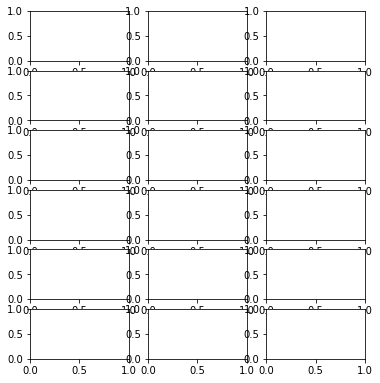

In [96]:
fig, axes = plt.subplots(6, 3, figsize=(6, 6.4))
varnames = varnames = this_model.free_RVs #this_model.untransformed_freeRVs
print("Possible varnames are :")
print(varnames)

In [97]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 0])

In [99]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2"]
):
    cov19.plot._distribution(this_model, trace1, key, ax=axes[i, 0])

In [100]:
for i, key in enumerate(
    # left column
    ["weekend_factor", "mu", "lambda_0", "lambda_1", "lambda_2", "lambda_3"]
):
    cov19.plot._distribution(this_model, trace2, key, ax=axes[i, 0])

In [101]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i, 1])

In [102]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        # "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace1, key, ax=axes[i, 1])

In [103]:
for i, key in enumerate(
    # mid column
    [
        "offset_modulation",
        "sigma_obs",
        "I_begin",
        "transient_day_1",
        "transient_day_2",
        "transient_day_3",
    ]
):
    cov19.plot._distribution(this_model, trace2, key, ax=axes[i, 1])

In [87]:
for i, key in enumerate(
    # right column
    ["delay", "transient_len_1", "transient_len_2", "transient_len_3",]
):
    cov19.plot._distribution(this_model, trace, key, ax=axes[i + 2, 2])

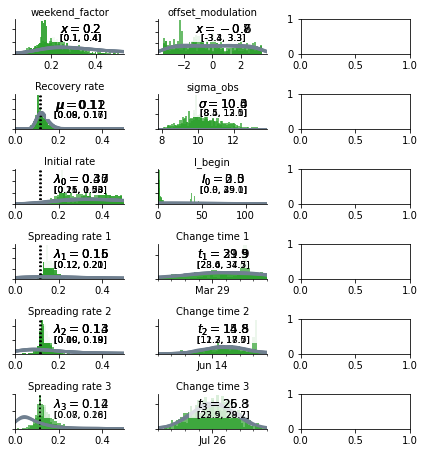

In [104]:
fig.tight_layout()
fig #To print in jupyter notebook


### Timeseries
timeseries overview, for now needs an offset variable to get cumulative cases


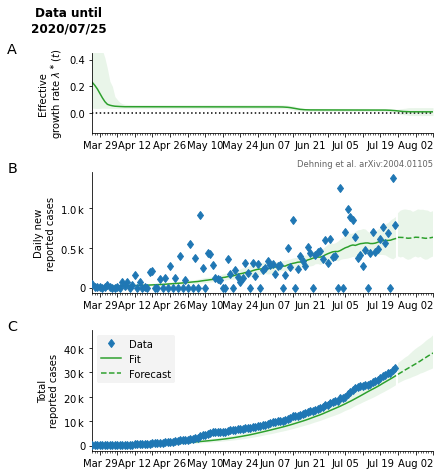

In [105]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace, offset=total_cases_obs[0])

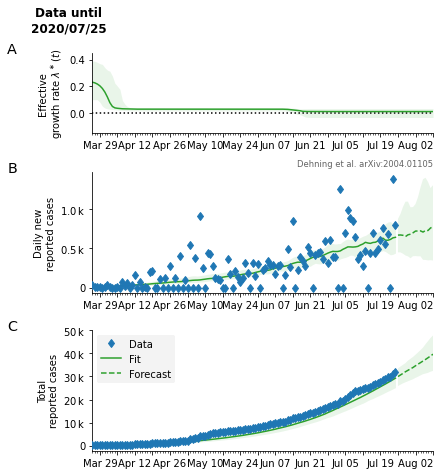

In [106]:
fig, axes = cov19.plot.timeseries_overview(this_model, trace1, offset=total_cases_obs[0])
